In [ ]:
# [Paper](./assets/bengio03.pdf)

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

%matplotlib inline
g = torch.Generator().manual_seed(2147483647) # for reproducibility

torch.__version__

'2.1.1+cu121'

In [2]:
import random
with open("names.txt", "r+") as f:
	words = f.read().splitlines()
	words = [word.strip() for word in words] # get rid of any trailing spaces
	words = [w for w in words if w] # get rid of any empty strings
	names = sorted(words, key=lambda x: random.random())
	
with open("names.txt", "w") as f: 
	joined = "\n".join(names)
	f.write(joined)
min_chars = 1
max_chars = max(len(v) for v in names)
chars = sorted(list(set("".join(names))))

# in replacement of the start and end token. Every name should end with a period. and there should be no start token to begin a sequence
chars = ['.'] + chars
chars_count = len(chars)
print("names: ", names[:5])
print("number of names: ", len(names))
print("(list of chars, count): ", ("".join(chars), chars_count))
print("(max word length, min word length): ", (max_chars, min_chars))

atoi = {ch:i for i,ch in enumerate(chars)}
itoa = {i:ch for i,ch in enumerate(chars)}

# adding end token to each name
names = [list(name) + ['.'] for name in names]

names:  ['dshawn', 'nayomi', 'ennio', 'lynix', 'laban']
number of names:  32033
(list of chars, count):  ('.abcdefghijklmnopqrstuvwxyz', 27)
(max word length, min word length):  (15, 1)


In [3]:
block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []

for name in names:
    context  = [0] * block_size
    for ch in name:
        ix = atoi[ch]
        X.append(context)
        Y.append(ix)
        # print(''.join(itoa[i] for i in context), '--->', itoa[ix])
        context = context[1:] + [ix] # crop and append
        
X, Y = torch.tensor(X), torch.tensor(Y)
X.shape, Y.shape, X.dtype, Y.dtype

(torch.Size([228146, 3]), torch.Size([228146]), torch.int64, torch.int64)

In [4]:
# build_dset basically builds a rolling window on the dataset based on the context length.
def build_dset(dset, ctxt_len):
    X, Y = [], []
    for name in dset:
        context  = [0] * ctxt_len
        for ch in name:
            ix = atoi[ch]
            X.append(context)
            Y.append(ix)
            # print(''.join(itoa[i] for i in context), '--->', itoa[ix])
            context = context[1:] + [ix] # crop and append
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y
n1 = int(0.1*len(words))
n2 = int(0.9*len(words))

X_train, Y_train = build_dset(names[:n1], block_size)
X_val, Y_val = build_dset(names[n1:n2], block_size)
X_test, Y_test = build_dset(names[n2:], block_size)

for c, d in zip(X_train[:5], Y_train[:5]):
    print(''.join(itoa[i.item()] for i in c), "=>", itoa[d.item()])

(X_train.shape, Y_train.shape), (X_val.shape, Y_val.shape), (X_test.shape, Y_test.shape)

... => d
..d => s
.ds => h
dsh => a
sha => w


((torch.Size([22851, 3]), torch.Size([22851])),
 (torch.Size([182482, 3]), torch.Size([182482])),
 (torch.Size([22813, 3]), torch.Size([22813])))

In [5]:
# squeezing it into a 2 dimensional space 
# since in the paper, a relatively smaller tensor(30 and 60) (to the dataset[17_000]) is used. 
C = torch.randn((27, 2), generator=g)

x_enc = F.one_hot(X_train, num_classes=27).float()
Z = x_enc @ C

# this is another way of doing x \times W 
emb = C[X_train]

assert torch.equal(Z, emb)
print("The shape of Z(emb): ", Z.shape)

The shape of Z(emb):  torch.Size([22851, 3, 2])


In [6]:
# changing shape of Z(emb) so as to cross weight 
A = torch.cat(torch.unbind(Z, 1), dim=1)
A.shape

# This is a more efficient implementation of the above
Z_shaped = Z.view(-1, 6)

assert torch.equal(A, Z_shaped)

# here let's use a 100 dimensional space
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
 
h = torch.tanh(Z_shaped @ W1 + b1) #hidden layer

print("Shape of hidden layer: ", h.shape)

W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)

logits = h @ W2 + b2 # log-counts
print("Shape of logits: ", logits.shape)

# normalization
counts = logits.exp()
probs = counts / counts.sum(1, keepdims=True)

print("Shape of probability space: ", probs.shape)

params = [C, W1, b1, W2, b2]

print("Total number of parameters: ", sum(p.nelement() for p in params))

Shape of hidden layer:  torch.Size([22851, 100])
Shape of logits:  torch.Size([22851, 27])
Shape of probability space:  torch.Size([22851, 27])
Total number of parameters:  3481


In [7]:
# negative mean log likelihood (cross entropy loss)
# print(probs.shape[0], Y_train.shape[0])
loss = -probs[torch.arange(probs.shape[0]), Y_train].log().mean()

# this is a better way to implement the above
loss2 = F.cross_entropy(logits, Y_train)

print(f"loss={loss} loss2={loss2}")
# assert torch.equal(loss, loss2), 

loss=19.553741455078125 loss2=19.553743362426758


In [8]:
# REDOING IT AGAIN MORE CLEARELY
# hyper-params
embedding_size = 10
block_size  = 3 # context length
mid_w_size = 200 # intermediate weight size
lr = 0.1 # determined based on graph
batch_size = 50

lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre # a range of learning rate
print(lrs.dtype)

torch.float32


In [9]:
# BACKPROPAGATION


# train-test split(80, 10, 10)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

X_train, Y_train = build_dset(names[:n1], block_size)
X_val, Y_val = build_dset(names[n1:n2], block_size)
X_test, Y_test = build_dset(names[n2:], block_size)

C = torch.randn((27, embedding_size), generator=g)
W1 = torch.randn((block_size * embedding_size, mid_w_size), generator=g)
b1 = torch.randn(mid_w_size, generator=g)
W2 = torch.randn((mid_w_size, 27), generator=g)
b2 = torch.randn(27, generator=g)

params = [C, W1, b1, W2, b2]

for p in params:
    p.requires_grad = True # autograd should record operations


In [10]:
# BACKPROPAGATION

# print(emb.shape, C[X_train].shape)  
count = 1000
step_i = []
lr_i = []
loss_i = []

for i in range(count):
    # minibatch construct - for efficiency
    ix = torch.randint(0, X_train.shape[0], (batch_size,))

    # forward pass
    emb = C[X_train[ix]].view(-1, 30)
    h = torch.tanh(emb @ W1 + b1) # intermediate layer
    logits = h @ W2 + b2
        
    loss = F.cross_entropy(logits, Y_train[ix])
    print("(", i ,"/", count, ") loss = ", loss.item())
    
    # backward pass
    for p in params:
        p.grad = None
    loss.backward()

    # update
    for p in params:
        p.data += - lrs[i] * p.grad 

    # track stats
    lr_i.append(lrs[i])
    step_i.append(i)
    loss_i.append(loss)

( 0 / 1000 ) loss =  23.184707641601562
( 1 / 1000 ) loss =  25.090444564819336
( 2 / 1000 ) loss =  27.188091278076172
( 3 / 1000 ) loss =  26.35101890563965
( 4 / 1000 ) loss =  26.69094467163086
( 5 / 1000 ) loss =  27.688766479492188
( 6 / 1000 ) loss =  24.560880661010742
( 7 / 1000 ) loss =  26.974740982055664
( 8 / 1000 ) loss =  27.420385360717773
( 9 / 1000 ) loss =  28.103239059448242
( 10 / 1000 ) loss =  24.744525909423828
( 11 / 1000 ) loss =  25.783374786376953
( 12 / 1000 ) loss =  26.49875259399414
( 13 / 1000 ) loss =  25.654233932495117
( 14 / 1000 ) loss =  27.859390258789062
( 15 / 1000 ) loss =  28.143417358398438
( 16 / 1000 ) loss =  29.63042640686035
( 17 / 1000 ) loss =  24.315793991088867
( 18 / 1000 ) loss =  25.764001846313477
( 19 / 1000 ) loss =  29.278032302856445
( 20 / 1000 ) loss =  27.93618392944336
( 21 / 1000 ) loss =  24.799291610717773
( 22 / 1000 ) loss =  23.619590759277344
( 23 / 1000 ) loss =  23.940040588378906
( 24 / 1000 ) loss =  26.490129

The minimum learning rate is:  -0.4834834933280945


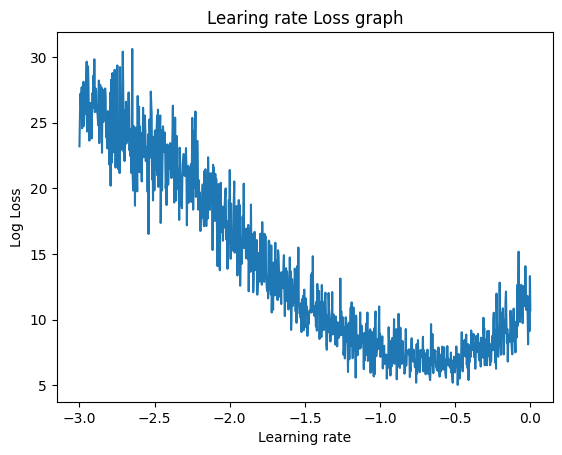

In [11]:
y = torch.tensor(loss_i)
x = torch.log10(torch.tensor(lr_i))

xy_stack = torch.stack((x, y), dim=1)
min_y_idx = torch.argmin(y)
min_lr = xy_stack[min_y_idx]
print("The minimum learning rate is: ", min_lr[0].item())

# graphing
plt.plot(x.numpy(), y.numpy()) # after determine the optimum learning rate
plt.xlabel('Learning rate')
plt.ylabel('Log Loss')
plt.title('Learing rate Loss graph')
plt.show()

In [ ]:
# BACKPROPAGATION

# print(emb.shape, C[X_train].shape)  
count = 200000

for i in range(count):
    # minibatch construct - for efficiency
    ix = torch.randint(0, X_train.shape[0], (batch_size,))

    # forward pass
    emb = C[X_train[ix]].view(-1, 30)
    h = torch.tanh(emb @ W1 + b1) # intermediate layer
    logits = h @ W2 + b2
        
    loss = F.cross_entropy(logits, Y_train[ix])
    if i % 100 == 0:
        print("(", i ,"/", count, ") loss = ", loss.item())
    
    # backward pass
    for p in params:
        p.grad = None
    loss.backward()

    # update
    lr_i = lr if i < 100000 else lr * 0.1
    # lr_i = 0.01
    for p in params:
        p.data += - lr_i * p.grad 

( 0 / 200000 ) loss =  10.368656158447266
( 1 / 200000 ) loss =  8.928363800048828
( 2 / 200000 ) loss =  8.754297256469727
( 3 / 200000 ) loss =  8.584981918334961
( 4 / 200000 ) loss =  6.709982395172119
( 5 / 200000 ) loss =  8.55643081665039
( 6 / 200000 ) loss =  8.267943382263184
( 7 / 200000 ) loss =  7.215545654296875
( 8 / 200000 ) loss =  9.278191566467285
( 9 / 200000 ) loss =  7.602297306060791
( 10 / 200000 ) loss =  7.16318416595459
( 11 / 200000 ) loss =  7.381515026092529
( 12 / 200000 ) loss =  6.4254841804504395
( 13 / 200000 ) loss =  6.835827827453613
( 14 / 200000 ) loss =  6.970251560211182
( 15 / 200000 ) loss =  6.603930473327637
( 16 / 200000 ) loss =  5.568823337554932
( 17 / 200000 ) loss =  5.829884052276611
( 18 / 200000 ) loss =  7.090150833129883
( 19 / 200000 ) loss =  6.432239532470703
( 20 / 200000 ) loss =  5.317622661590576
( 21 / 200000 ) loss =  7.220716953277588
( 22 / 200000 ) loss =  5.947997570037842
( 23 / 200000 ) loss =  5.655766487121582
( 

In [ ]:
X, Y = X_val, Y_val # validation set
emb = C[X]
h = torch.tanh(emb.view(-1, block_size * embedding_size) @ W1 + b1) # intermediate layer
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y)
loss.item()

In [ ]:
X, Y = X_test, Y_test # test set
emb = C[X]
h = torch.tanh(emb.view(-1, block_size * embedding_size) @ W1 + b1) # intermediate layer
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y)
loss.item()

In [ ]:
def nnl(probs, name):
    "to calculate the likelihood of a word"
    i = torch.tensor([atoi[ch] for ch in name])
    x, y = build_dset([name], block_size)
    emb = C[x]
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    return loss.item()

In [ ]:
# sampling

for i in range(10):
    out = []
    context  = [0] * block_size
    while True:
        emb = C[torch.tensor(context)].view(-1, block_size * embedding_size)
        h = torch.tanh(emb @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g)
        context = context[1:] + [ix]
        out.append(ix)
        
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))

In [ ]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')